# TorchVision Faster R-CNN Finetuning Tutorial

Based on [TorchVision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

For this tutorial, we will be finetuning a pre-trained Faster R-CNN model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset. To run the notebook, download the dataset, unzip it and move it into the `data/` directory.

## Defining the Dataset

The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

Specifically for the torchvision reference scripts to work, the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.

**See `lib.penn_fundan` for the dataset implementation.**

## Defining your model

In this tutorial, we will be using [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a ResNet-50 FPN backbone. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

In [1]:
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn


model = fasterrcnn_resnet50_fpn(pretrained=True)

## Training and evaluation functions

We will be using a modification from [torchvision reference scripts for training object detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) that are included in the torchvision repository. This includes code for the training loop, evaluation with COCO metrics and image transformation utilities, so we don't need to write all these things ourselves.

The scripts are in the directory `lib/detection/`.

In [2]:
import lib.detection.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [3]:
from lib.penn_fundan import PennFudanDataset

dataset_train = PennFudanDataset('data/PennFudanPed/', get_transform(train=True))
dataset_val = PennFudanDataset('data/PennFudanPed/', get_transform(train=False))

In [4]:
from torch.utils.data import DataLoader
from lib.detection.utils import collate_fn


# define training and validation data loaders
data_loader_train = DataLoader(
    dataset_train, batch_size=1, shuffle=True, num_workers=12,
    collate_fn=collate_fn
)

data_loader_val = DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=12,
    collate_fn=collate_fn
)

Now let's instantiate the model and the optimizer

In [5]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.optim import SGD


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and product
num_classes = 2

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = StepLR(optimizer,
                      step_size=3,
                      gamma=0.1)

In [6]:
import tensorboard

%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 7239), started 0:29:32 ago. (Use '!kill 7239' to kill it.)

And now let's train the model for a couple of epochs, evaluating at the end of every epoch.

In [7]:
from lib.detection.engine import train_one_epoch, evaluate
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

num_epochs = 10

writer = SummaryWriter()

for epoch in tqdm(range(num_epochs), desc='Epoch'):
    train_one_epoch(model, optimizer, data_loader_train,
                    device, epoch, writer=writer)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_val, device, epoch, writer=writer)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

/home/fdf/clones/maibi_cv/.venv/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.940
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.825
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.825
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.796
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.996
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.844
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.849
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.878
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.878
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.829
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.880
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.853
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.884
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.909
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.909
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.877
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.890
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.894
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.919
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.919
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.894
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.909
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.875
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.913
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.909
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.913
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.903
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.904
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.909
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.930
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.930
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.906
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.911
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.931
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.931
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.889
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.931
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.931
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Now that training has finished, let's have a look at what it actually predicts in a test image

In [8]:
# pick one image from the test set
img, _ = dataset_val[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels` and `scores` as fields.

In [9]:
prediction

[{'boxes': tensor([[157.6651, 182.4619, 297.2635, 430.3134],
          [419.4796, 171.7353, 531.5698, 488.5543]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9988, 0.9985], device='cuda:0')}]

Let's inspect the image and the predicted detection boxes.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format. Next, we iterate over the predicted boxes and draw them on the images.

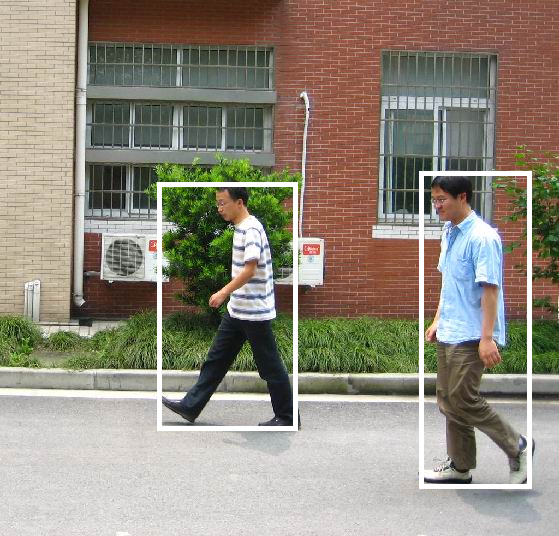

In [10]:
from PIL import Image, ImageDraw

im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(im)

for box in prediction[0]['boxes'].cpu().numpy():
    draw.rectangle(box, width=5)

im